In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.api import OLS,Logit
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import matplotlib.gridspec as gs
import seaborn as sns
import argparse
from scipy.stats import zscore,pearsonr,spearmanr
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from PRS import PRS # custom script to run PRS with DeGAs input data

/home/users/magu/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 1. load data
dataset='/oak/stanford/groups/mrivas/projects/degas-risk/datasets/train/tsvd/all_z_center_p001_20190805_500PCs.npz'
npc=300
phe_codes=['INI21001']
covariates=['age','sex']+['PC'+str(i+1) for i in range(4)]+['1']
score_pcs=['SCORE{}_SUM'.format(pc+1) for pc in range(npc)]
profl_pcs=['PROF_PC{}'.format(pc+1) for pc in range(npc)]
z=np.load(dataset)
scores=pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/scorefiles/'+
                      os.path.splitext(os.path.basename(dataset))[0]+'.sscore',
                     index_col='#IID')
phenos=pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariates[:-1],
                     index_col='IID',
                     na_values=-9)
phenos['1']=1
with open('/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

In [3]:
# 2. define population groupings
train=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_train.phe').iloc[:,0].astype(float).tolist())
valid=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_valid.phe').iloc[:,0].astype(float).tolist())
test=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_test.phe').iloc[:,0].astype(float).tolist())
nbw=set(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/'+
                         'ukb24983_non_british_white.phe').iloc[:,0].astype(float).tolist())
print(list(map(len,[train,valid,test,nbw])))

[236004, 33715, 67429, 24908]


In [4]:
# 3. analysis
for phe_code in phe_codes:
    # run PRS for this trait if not already done
    prs_f=os.path.join('/oak/stanford/groups/mrivas/projects/degas-risk/PRS/train/',
                       os.path.splitext(os.path.basename(dataset))[0][:-7], 
                       phe_code+'_PRS.profile')
    if not os.path.exists(prs_f):
        PRS(dataset.replace('tsvd/','').replace('_500PCs.npz','.full_df.pkl.gz'), phe_code)
    prs=pd.read_table(prs_f, sep='\s+', usecols=['IID','SCORESUM'], index_col='IID').rename(columns={'SCORESUM':'PRS'})
    # name phenotype, set up datasets
    phe_name=code_to_name[phe_code]
    df=phenos.loc[train | valid | test | nbw, [phe_code]+covariates].dropna()
    df=df.merge(scores, left_index=True, right_index=True).merge(prs, left_index=True, right_index=True)
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['dPRS']=df[score_pcs].dot(weights)
    # is trait binary or quantitative?
    is_bin=(len(df[phe_code].value_counts()) == 2)
    if is_bin: 
        df[phe_code]-=1
        regress=Logit
    else:
        regress=OLS
    # setup for regression models
    models={prs:{m:{} for m in ['RAW','COVAR','RESID','JOINT']} for prs in ['PRS','dPRS']}
    params={prs:{'RAW':[prs], 'COVAR':covariates, 'JOINT':covariates+[prs]} for prs in ['PRS','dPRS']}
    stats ={prs:pd.DataFrame(index=['train','valid','test','nbw'], 
                             columns=['n','beta2','auc','pearsonr','spearmanr']) for prs in ['PRS','dPRS']}
    # iterate through populations, fit/predict/compute stats
    for prs in ['PRS','dPRS']:
        for pop_id,pop in zip(['train','valid','test','nbw'],[train,valid,test,nbw]):
            # take a new subset
            df2=df.loc[pop,:].dropna()
            pop=[ind for ind in pop if ind in df2.index]
            # zscore (d)PRS within the phenotype group; trait too if quantitative
            df2[prs]=zscore(df2[prs])
            if not is_bin:
                df2[phe_code]=zscore(df2[phe_code])
            # loop over models: dPRS alone, covars alone, dPRS ~ resid(phe ~ covars), joint model
            for m in ['RAW','COVAR','RESID','JOINT']:
                # use covariate model fit within population, regress on residuals
                if m=='RESID':
                    models[prs][m][pop_id]=OLS(models[prs]['COVAR'][pop_id].resid_pearson, 
                                               df2.loc[pop,prs]).fit(disp=0)
                # use joint model fit in validation for test and nbw; fit in train for test
                elif m=='JOINT' and pop_id in ['test','nbw']:
                    models[prs][m][pop_id]=models[prs][m]['valid']
                elif m=='JOINT' and pop_id == 'valid':
                    models[prs][m][pop_id]=models[prs][m]['train']
                # otherwise just fit and assess within the same group
                else:
                    models[prs][m][pop_id]=regress(df2.loc[pop,phe_code], df2.loc[pop,params[prs][m]]).fit(disp=0)
            # re-sort based on adjusted dPRS
            df2['jPRS']=models[prs]['JOINT'][pop_id].predict(df2[params[prs]['JOINT']])
            df2=df2.sort_values('jPRS').drop('jPRS', axis=1)
            # compute these stats: # beta/OR of top 2% versus entire group; AUC of joint model (bin); 
            # r of resid model (qt); N; and spearman rho between dPRS and trait (bin & QT)
            if is_bin:
                p1,p2=df2[phe_code].iloc[-int(0.02*len(pop)):].mean(), df2[phe_code].mean() # beta helper
                stats[prs].loc[pop_id,'beta2']=np.log(p1*(1-p2)/(p2*(1-p1)))
                stats[prs].loc[pop_id,'auc']=roc_auc_score(df2.loc[pop,phe_code], models[prs]['JOINT'][pop_id].predict(
                                                                                    df2.loc[pop,params[prs]['JOINT']]))
                stats[prs].loc[pop_id,'pearsonr']='na'
                stats[prs].loc[pop_id,'n']=df2.loc[pop,phe_code].value_counts().loc[1]
            else:
                stats[prs].loc[pop_id,'beta2']=df2[phe_code].iloc[-int(0.02*len(pop)):].mean() - df2[phe_code].mean()
                stats[prs].loc[pop_id,'auc']='na'
                stats[prs].loc[pop_id,'pearsonr']=pearsonr(models[prs]['COVAR'][pop_id].resid, df2.loc[pop,prs])[0]
                stats[prs].loc[pop_id,'n']=df2.loc[pop,phe_code].shape[0]
            stats[prs].loc[pop_id,'spearmanr']=spearmanr(df2.loc[pop,phe_code],df2.loc[pop,prs])[0]
        print(prs)
        print(stats[prs])

PRS
            n     beta2 auc  pearsonr spearmanr
train  235257  0.940252  na  0.348544  0.339179
valid   33610   0.57819  na  0.215352  0.207073
test    67238  0.544524  na  0.204671  0.200277
nbw     24796  0.581556  na  0.198522  0.204977
dPRS
            n     beta2 auc  pearsonr spearmanr
train  235257  0.951806  na  0.351193  0.339509
valid   33610  0.606442  na  0.215175  0.206272
test    67238  0.513412  na  0.206574   0.20155
nbw     24796  0.579017  na  0.199108  0.206097


/home/users/magu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PC3: 60.8%, PC7: 3.8%, PC16: 1.6%, PC169: 1.4%, PC2: 1.2%
PC1: 73.8%, PC6: 4.3%, PC13: 1.7%, PC168: 0.8%, PC26: 0.7%


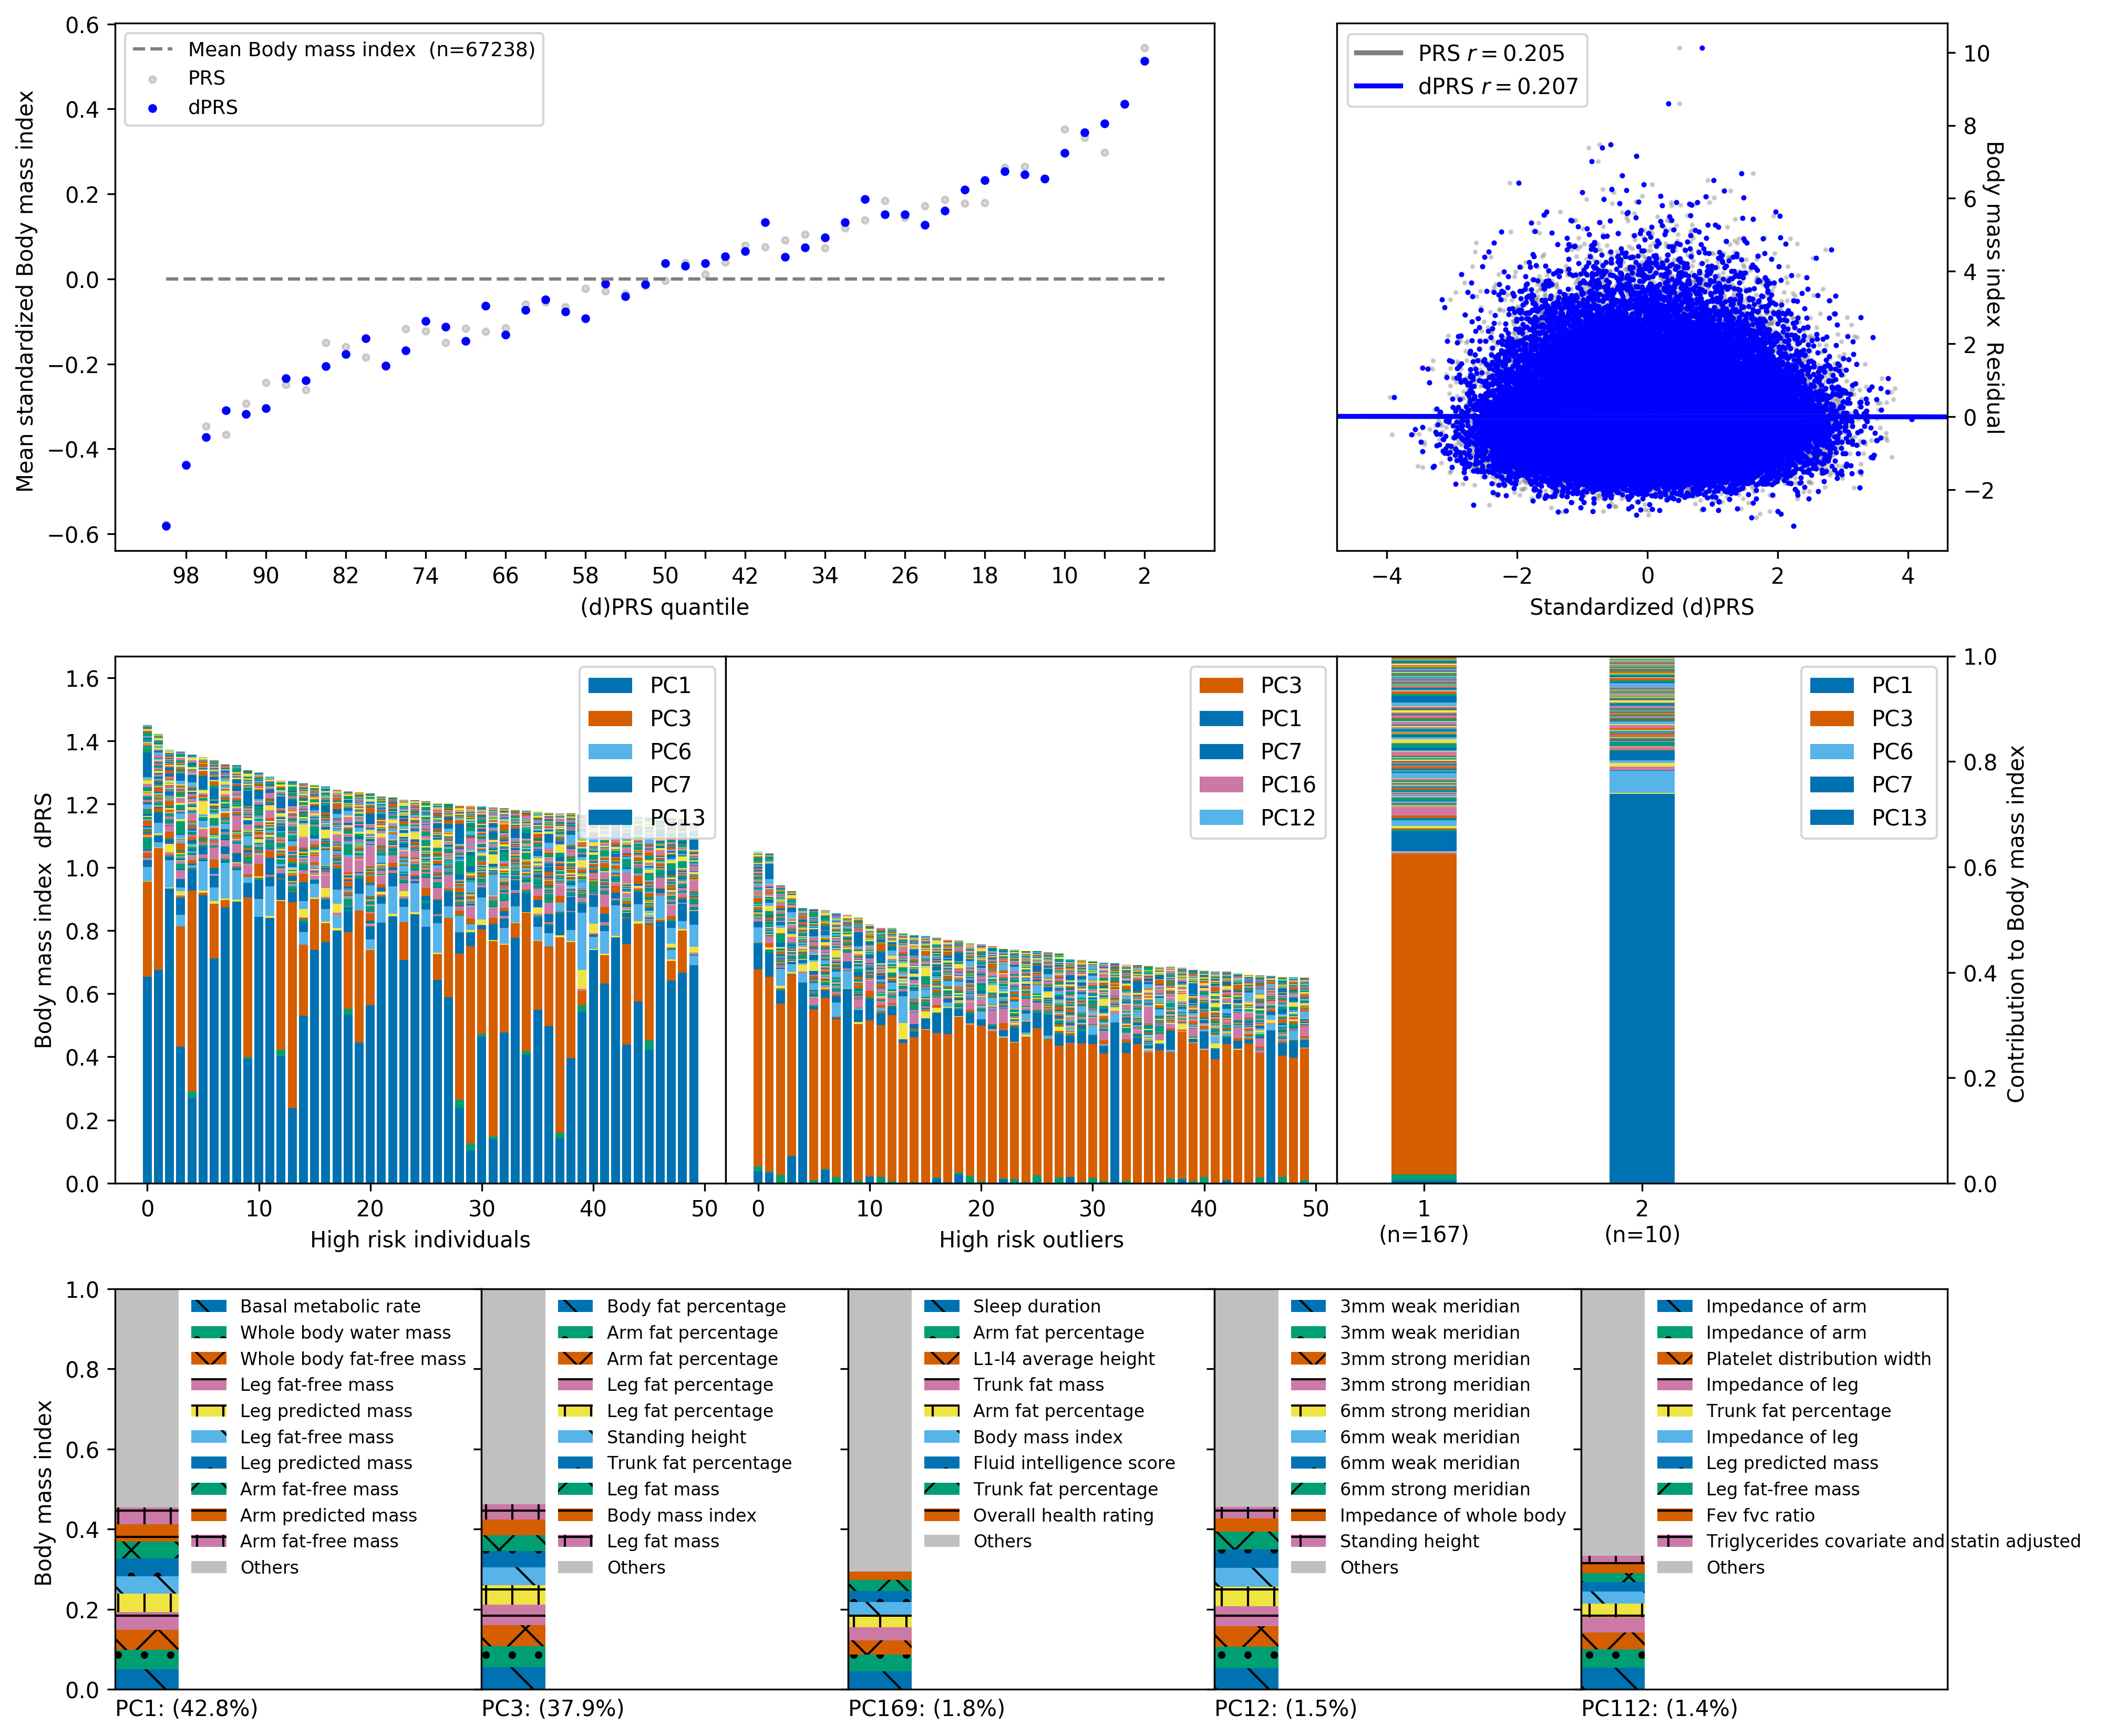

In [6]:
width = 2
# initialize plot objects
plots = [None for _ in range(10)]
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(15, 14), dpi=300)
grid=gs.GridSpec(14, 15, wspace=0, hspace=5)
        
for pop_id,pop in zip(['test'], [test]):
    # setup plot
    plots[0]=plt.subplot(grid[:5,:9])
    plots[1]=plt.subplot(grid[:5,10:])
    plots[2]=plt.subplot(grid[5:10,:5])
    plots[3]=plt.subplot(grid[5:10,5:10])
    plots[4]=plt.subplot(grid[5:10,10:])
    plots[5]=plt.subplot(grid[10:,:3])
    plots[6]=plt.subplot(grid[10:,3:6])
    plots[7]=plt.subplot(grid[10:,6:9])
    plots[8]=plt.subplot(grid[10:,9:12])
    plots[9]=plt.subplot(grid[10:,12:])
    # take a new subset
    df2=df.loc[[i for i in pop if i in df.index],:].copy().dropna()
    pop=df2.index.tolist()
    if not is_bin:
        df2[phe_code]=zscore(df2[phe_code])
    # (A) do quantile plot with modified (only if binary) phenotype
    n,nq=len(pop),50
    for prs in ['PRS','dPRS']:
        df2[prs]=zscore(df2[prs])
        df2['j'+prs]=models[prs]['JOINT']['valid'].predict(df2[params[prs]['JOINT']])
        df2=df2.sort_values('j'+prs, ascending=True)
        plots[0].scatter(np.arange(nq), 
                        [df2.iloc[int(q*n/nq):int((q+1)*n/nq),:][phe_code].mean() for q in range(nq)], 
                         s=9, c='b' if prs=='dPRS' else 'grey', alpha=0.3+0.7*(prs=='dPRS'))
    # labels
    plots[0].set_ylabel('{0}{1}{2}'.format('Mean standardized ' if not is_bin else '',
                                            code_to_name[phe_code], ' prevalence' if is_bin else ''))
    plots[0].set_xticks(np.arange(1,nq+1,2))
    plots[0].set_xticklabels([int(100*q/nq) if q%4==1 else '' for q in reversed(range(1,nq+1,2))])
    plots[0].set_xlabel('(d)PRS quantile')
    plots[0].plot([0,nq],[df2.loc[pop,phe_code].mean(), df2.loc[pop,phe_code].mean()],'--',color='grey')
    plots[0].legend(['{0}{1}{2} (n={3})'.format('' if is_bin else 'Mean ',
                                                code_to_name[phe_code],
                                                ' prevalence' if is_bin else '',
                                                int(df2[phe_code].sum()) if is_bin else len(pop))]+['PRS','dPRS'], 
                    loc=2, fontsize=9)
    # adjust y-axis to display odds ratios as well as prevalence (only binary traits)
    if is_bin:
        y_or=plots[0].twinx()
        or_to_prev=lambda o: o*df2[phe_code].mean()/(1+(df2[phe_code].mean()*(o-1)))
        y_or.set_yticks([or_to_prev(o) for o in [0,0.5,1,2,3,4,5,6,7,8,9] 
                          if df2.iloc[-(n/nq):,:][phe_code].mean() > or_to_prev(o-1) 
                          and plots[0].get_ylim()[0] <= or_to_prev(o)])
        y_or.set_yticklabels(map(lambda s:str(s), 
                                 filter(lambda o: df2.iloc[-(n/nq):,:][phe_code].mean() > or_to_prev(o-1) 
                                                  and plots[0].get_ylim()[0] <= or_to_prev(o),
                                        [0,0.5,1,2,3,4,5,6,7,8,9])))
        y_or.set_ylim(plots[0].get_ylim())
        y_or.set_ylabel('OR',rotation=270) 

    # (B) plot ROC/correlation plot
    if is_bin:
        # loop over dPRS and these joint models
        for w,(prs,mt) in enumerate(zip(['PRS','dPRS','dPRS','dPRS'],['RAW','RAW','COVAR','JOINT'])):
            # compute stats, plot them
            fpr,tpr,_=roc_curve(  df2.loc[pop,phe_code], 
                                  models[prs][mt][pop_id].predict(df2.loc[pop,params[prs][mt]]))
            roc_auc=roc_auc_score(df2.loc[pop,phe_code], 
                                  models[prs][mt][pop_id].predict(df2.loc[pop,params[prs][mt]]))
            plots[1].plot(fpr, tpr, 
                          label='{0} AUC={1:.3f}'.format(prs if mt=='RAW' else mt.capitalize().replace('r', 'riate'),
                                                         roc_auc), 
                          color='b' if w%2 else 'grey', alpha=0.7+0.3*(w%2), linestyle='-' if w/2 else '-.')
        # add null line, axis labels
        plots[1].plot([0, 1],[0, 1],'k--',label='Random classification')
        plots[1].legend(fontsize=9)
        plots[1].set_xlim([0.0, 1.0])
        plots[1].set_ylim([0.0, 1.05])
        plots[1].set_xlabel('FPR')
        plots[1].set_ylabel('TPR', rotation=270)
    else:
        # plot correlation with dPRS and standardized residual phenotype
        df2.loc[pop,phe_code]=zscore(df2.loc[pop,phe_code])
        for prs in ['PRS','dPRS']: # scoresum is PRS, score is dPRS -- confused yet? me too.
            sns.regplot(x=df2[prs], y=models[prs]['COVAR'][pop_id].resid_pearson, 
                        ax=plots[1],
                        scatter_kws={'s':2, 'alpha':0.3+0.7*(prs!='PRS')}, 
                        color='b' if prs == 'dPRS' else 'grey')
        plots[1].set_ylabel(code_to_name[phe_code]+' Residual', rotation=270)
        plots[1].legend([prs+' '+'$r=$'+'{:.3f}'.format(pearsonr(models[prs]['COVAR'][pop_id].resid_pearson, 
                                                                 df2.loc[pop,prs])[0]) for prs in ['PRS','dPRS']])
        plots[1].set_xlabel('Standardized (d)PRS')
    plots[1].yaxis.tick_right()
    plots[1].yaxis.set_label_position("right")
    
    # (C): high risk individuals (first compute profiles)
    for pc in range(npc):
        df2[profl_pcs[pc]]=(df2[score_pcs[pc]] * weights[pc] * df2['j'+prs]).clip_lower(0)
    df2[profl_pcs] = normalize(df2[profl_pcs], norm='l1')
    # now plot
    o, pc_plots=50, []
    dfo=df2.iloc[-o:,:][::-1]
    top5pc=np.argsort(dfo['j'+prs].dot(dfo[profl_pcs])[:npc])[-5:][::-1]
    for pc in range(npc):
        pp=plots[2].bar(np.arange(o), 
                        dfo[profl_pcs[pc]] * dfo['j'+prs],
                        bottom=np.array(dfo[profl_pcs[:pc]].sum(axis=1) * dfo['j'+prs])#,
                        # hatch=pcps[pc+1] if pc+1 in pcps else None
                        )
        pc_plots.append(pp)
    # axis labels and such
    plots[2].set_ylim(0, 1.15*df2['j'+prs].max())
    plots[2].set_ylabel(phe_name+' dPRS')
    plots[2].set_xlabel('High risk individuals')
    plots[2].legend([pc_plots[pc] for pc in top5pc], ['PC'+str(pc+1) for pc in top5pc], loc=1)
    
    # (D): outliers (first find them)
    centroid=df2[profl_pcs].median()
    df3=df2.iloc[-int(0.1*len(pop)):]
    df3['mahal']=df3[profl_pcs].apply(lambda x: euclidean(x, centroid), axis=1)
    m_star=df3['mahal'].mean() + 2*df3['mahal'].std()
    outliers=df3.query('mahal > @m_star').index
    
    # now plot them
    dfo=df2.loc[outliers[-o:],:][::-1]
    top5pc=np.argsort(dfo['j'+prs].dot(dfo[profl_pcs])[:npc])[-5:][::-1]
    pc_plots2=[]
    for pc in range(npc):
        pp=plots[3].bar(np.arange(o), 
                        dfo[profl_pcs[pc]] * dfo['j'+prs],
                        bottom=np.array(dfo[profl_pcs[:pc]].sum(axis=1) * dfo['j'+prs])#,
                        # hatch=pcps[pc+1] if pc+1 in pcps else None
                        )
        pc_plots2.append(pp)
    # axis labels and such
    plots[3].set_ylim(0, 1.15*df2['j'+prs].max())
    plots[3].set_ylabel(''); plots[3].set_yticks([])
    plots[3].set_xlabel('High risk outliers')
    plots[3].legend([pc_plots[pc] for pc in top5pc], ['PC'+str(i+1) for i in top5pc], loc=1)    
    
    # (E): Cluster centers (first compute them)
    k=1
    cluster = KMeans(n_clusters=k, n_init=25).fit(df3.loc[outliers,profl_pcs])
    pre_frac = 0.8 - 10.0/len(outliers)
    errors = [cluster.inertia_]
    for new_k in [2,3,4,5]:
        new_cluster = KMeans(n_clusters=new_k, n_init=25).fit(df3.loc[outliers,profl_pcs])
        errors.append(new_cluster.inertia_)
        if new_cluster.inertia_ / cluster.inertia_ < pre_frac**(new_k - k): 
            cluster,k = new_cluster,new_k
    
    # now plot them
    ms = cluster.cluster_centers_[0:k]
    x,p = np.arange(k), []
    top5pcs = np.argsort(np.sum(ms, axis=0))[-5:]
    for pc in range(ms.shape[1]):
        zz=plots[4].bar(x, ms[:,pc], bottom=np.sum(ms[:,0:pc], axis=1), width=0.3)#,
                                     #hatch=pcps[pc+1] if pc+1 in pcps else None)
        p.append(zz)
    # print out cluster centroids
    for j in range(ms.shape[0]):
        print(', '.join([': '.join(('PC'+str(pc+1),'{:.1f}%'.format(100*f))) for pc,f in sorted(enumerate(ms[j,:]), 
                                                                                       key=lambda x:-x[1])[:5]]))
    # axis label
    plots[4].set_xlabel('')
    plots[4].set_ylabel('Contribution to '+phe_name)
    plots[4].set_ylim((0, 1))
    plots[4].set_xlim((-0.4,k+0.4))
    plots[4].set_xticks(np.arange(k))
    plots[4].set_xticklabels([str(x+1)+'\n(n='+str(y)+')' 
                                for x,y in enumerate(list(pd.Series(cluster.labels_).value_counts()))])
    plots[4].legend([p[i] for i in reversed(top5pcs)], ['PC' + str(i+1) for i in reversed(top5pcs)])
    plots[4].yaxis.tick_right()
    plots[4].yaxis.set_label_position("right")
    
    # (F-J): Components
    V = z['V'] * z['D']
    pix=np.where(z['label_phe_code']==phe_code)
    patterns = ('.', 'x', '-', '+', '\\')
    for pcx in range(5):
        # setup: figure, which component, traits therein
        pc=np.argsort(V[pix,:]**2).flatten()[-(pcx+1)]
        ranked_phes=np.argsort(V[:,pc]**2)[::-1].flatten()
        # loop over top 10 traits, plot bars if bar above 1%
        for ix,phe_ix in enumerate(ranked_phes[:10]):
            if (z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2) > 0.02:
                plots[5+pcx].bar([0], [(z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2)], 
                                 bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2),
                                 label=code_to_name[z['label_phe_code'][phe_ix]],
                                 hatch=patterns[(ix + 4) % len(patterns) ]
                                )
            else: ix-=1; break
        ix+=1
        # add grey bar on top
        plots[5+pcx].bar([0], [1-(np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2))],
                         bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2), 
                         color='silver', label='Others')
        # adjust figure ticks/limits; add labels
        plots[5+pcx].set_ylim(0,1); 
        plots[5+pcx].set_xlim(0,2.3)
        plots[5+pcx].set_xticks([],[])
        plots[5+pcx].set_xlabel('PC{0}: ({1:.1f}%)'.format(pc+1, 100*((V[pix,pc]**2)/np.sum(V[pix,:]**2))[0][0]), 
                                 horizontalalignment='left', x=0.0)
        if pcx==0:
            plots[5].set_ylabel(code_to_name[phe_code])
        else:
            plots[5+pcx].set_yticklabels(['' for _ in plots[5+pcx].get_yticks()])
        lgd=plots[5+pcx].legend(loc='upper left', bbox_to_anchor=(0.165, 1.015), frameon=False, fontsize=8)    
    
    # at the end: display lexicographic labels
    # for i in range(6):
    #     plots[i].text(-0.1, 1.05, chr(i+65), fontsize=16, transform=plots[i].transAxes)


plt.show()
# fig.savefig("pdfs/fig2.pdf", bbox_inches='tight')